In [1]:
import os
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud
import sys
sys.maxunicode
import spacy
from spacy.matcher import Matcher
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords as sws
stopwords = sws.words('english')
#import neuralcoref # cauing kernel killed
import string
from collections import Counter
import re

[nltk_data] Downloading package stopwords to /home/ym310/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
reviews = pd.read_json(r'train_reviews.json')
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2021 entries, 0 to 2020
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype              
---  ------  --------------  -----              
 0   date    2021 non-null   datetime64[ns, UTC]
 1   title   2021 non-null   object             
 2   text    2021 non-null   object             
 3   url     2021 non-null   object             
 4   stars   2021 non-null   object             
dtypes: datetime64[ns, UTC](1), object(4)
memory usage: 79.1+ KB


In [3]:
# in previous attemp I found some duplicated reviews
reviews.drop_duplicates(subset=['date', 'title', 'text', 'url', 'stars'], keep=False, inplace=True)
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1621 entries, 0 to 2020
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype              
---  ------  --------------  -----              
 0   date    1621 non-null   datetime64[ns, UTC]
 1   title   1621 non-null   object             
 2   text    1621 non-null   object             
 3   url     1621 non-null   object             
 4   stars   1621 non-null   object             
dtypes: datetime64[ns, UTC](1), object(4)
memory usage: 76.0+ KB


In [4]:
# great, no null data found
reviews['date'] = pd.to_datetime(reviews['date'].astype(str), format='%Y-%m-%d %H:%M:%S')
reviews.sort_values(by=['date'], inplace=True, ascending=True)
reviews['year'] = reviews['date'].map(lambda x:x.year)
reviews['month'] = pd.to_datetime(reviews.date).dt.to_period('m')
# should avoid deep copy
reviews_cp = reviews.set_index('date', inplace=False)
reviews_cp.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1621 entries, 2011-05-28 15:00:36+00:00 to 2018-07-17 13:59:52+00:00
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype    
---  ------  --------------  -----    
 0   title   1621 non-null   object   
 1   text    1621 non-null   object   
 2   url     1621 non-null   object   
 3   stars   1621 non-null   object   
 4   year    1621 non-null   int64    
 5   month   1621 non-null   period[M]
dtypes: int64(1), object(4), period[M](1)
memory usage: 88.6+ KB


/home/ym310/anaconda3/envs/pt3/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:1091: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


In [5]:
reviews_cp['level'] = reviews_cp['stars'].str.extract('(\d+)').apply(pd.to_numeric)

In [6]:
reviews_cp['level'].value_counts()

1    1281
5     133
2     116
4      49
3      42
Name: level, dtype: int64

/home/ym310/anaconda3/envs/pt3/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


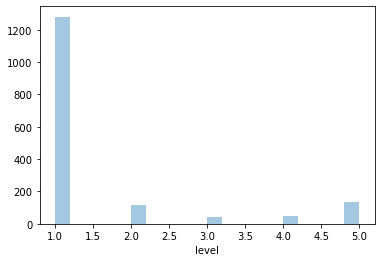

In [7]:
sns.distplot(reviews_cp['level'], kde=False, norm_hist=False, bins=20)

In [8]:
reviews_cp['sources'] = reviews_cp['url'].str.extract('https://uk.trustpilot.com/review/([^/|?]+)')

In [9]:
reviews_cp['sources'].value_counts()

www.virgintrains.co.uk                     500
www.southernrailway.com                    280
www.gwr.com                                200
www.eurostar.com                           200
www.virgintrainseastcoast.com              140
www.nationalrail.co.uk                      65
www.arrivatrainswales.co.uk                 40
www.tpexpress.co.uk                         40
www.eastmidlandstrains.co.uk                40
www.buytickets.crosscountrytrains.co.uk     40
www.southeasternrailway.co.uk               20
www.grandcentralrail.com                    19
www.southwesternrailway.com                 13
chilternrailways.co.uk                       8
www.londonnorthwesternrailway.co.uk          8
sleeper.scot                                 6
www.hulltrains.co.uk                         2
Name: sources, dtype: int64

UsageError: Line magic function `%%capture` not found.


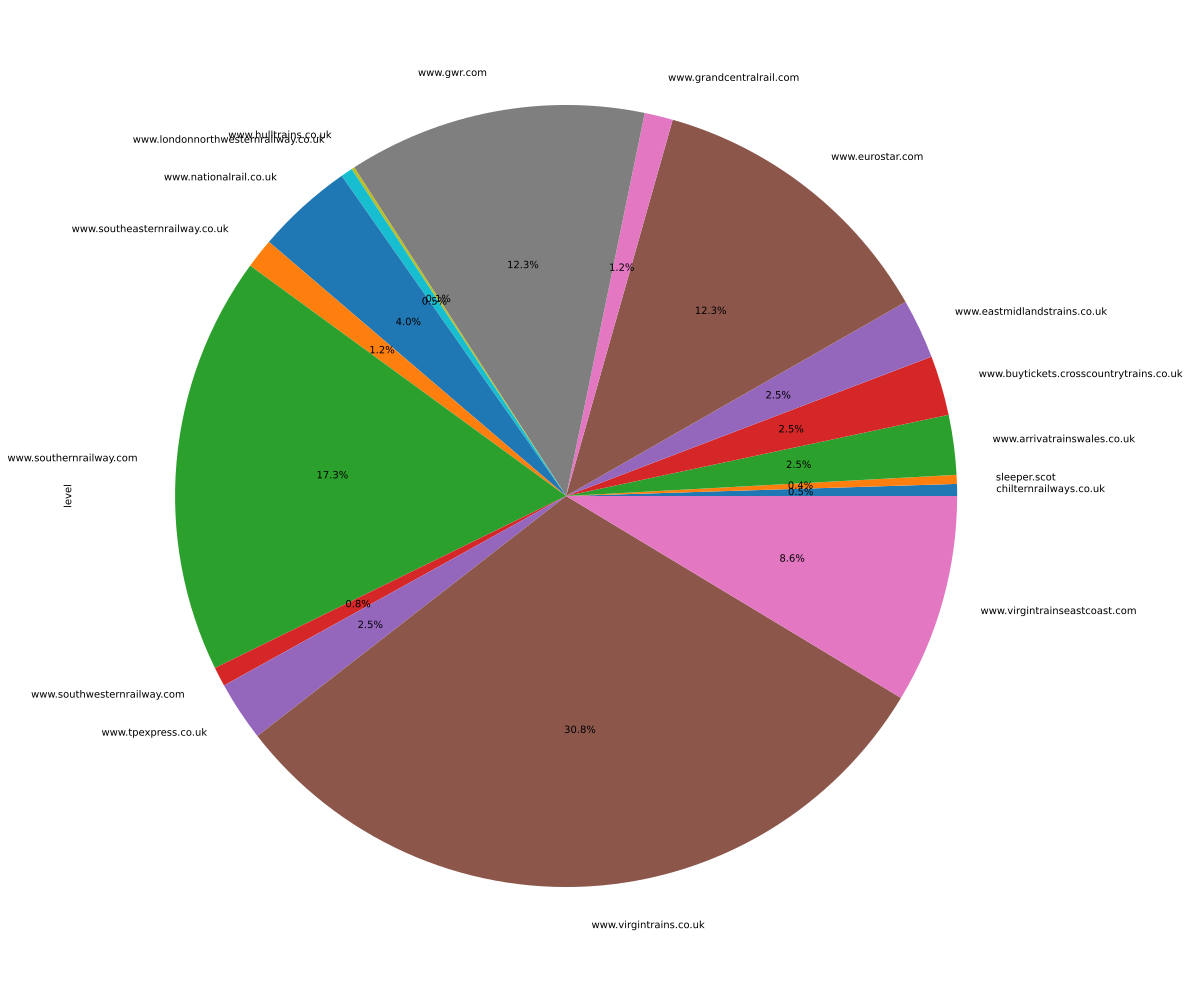

In [181]:
ss = reviews_cp.groupby(['sources'])['level'].count()
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
fig = plt.figure(figsize=(18,18))
ss.plot.pie(autopct="%.1f%%")
%%capture
#ss.first()

In [11]:
reviews_cp.loc[:, 'textCnt'] = reviews_cp['text'].apply(lambda x: len(x.split()))
text_sorted = reviews_cp.sort_values('textCnt', ascending=False)
print(len(text_sorted['text'][0]))

3773


In [12]:
Title = reviews_cp['title'].map(lambda x: re.sub(r'\W+', ' ', x))
Text = reviews_cp['text'].map(lambda x: re.sub(r'\W+', ' ', x))
Title.str.find('...')

date
2011-05-28 15:00:36+00:00   -1
2011-11-20 20:43:09+00:00   -1
2015-01-07 23:32:34+00:00   -1
2015-01-13 12:26:52+00:00   -1
2015-02-11 13:20:32+00:00   -1
                            ..
2018-07-17 08:54:14+00:00   -1
2018-07-17 09:32:06+00:00   -1
2018-07-17 09:32:06+00:00   -1
2018-07-17 13:59:52+00:00   -1
2018-07-17 13:59:52+00:00   -1
Name: title, Length: 1621, dtype: int64

In [13]:
# spacy & nlp
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe(nlp.create_pipe('sentencizer'))
#matcher = Matcher(nlp.vocab) # pattern match
#neuralcoref.add_to_pipe(nlp) # coreference resolution

In [14]:
# insights and topic modeling
punctuations = string.punctuation

def clean_up(user_reviews):
    texts = []
    counter = 1          
    for token in user_reviews:
        #print("Processed %d / %d." % (counter, 1621))
        counter += 1
        doc = nlp(token, disable=['parser','ner','tagger'])
        tk = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
        tk = [tok for tok in tk if tok not in stopwords and tok not in punctuations]
        tk = ' '.join(tk)
        texts.append(tk)
    return pd.Series(texts)

In [15]:
# remove stop words to reduce the noise in our data
title_clean = clean_up(Title)
title_clean = ' '.join(title_clean).split()

text_clean = clean_up(Text)
text_clean = ' '.join(text_clean).split()

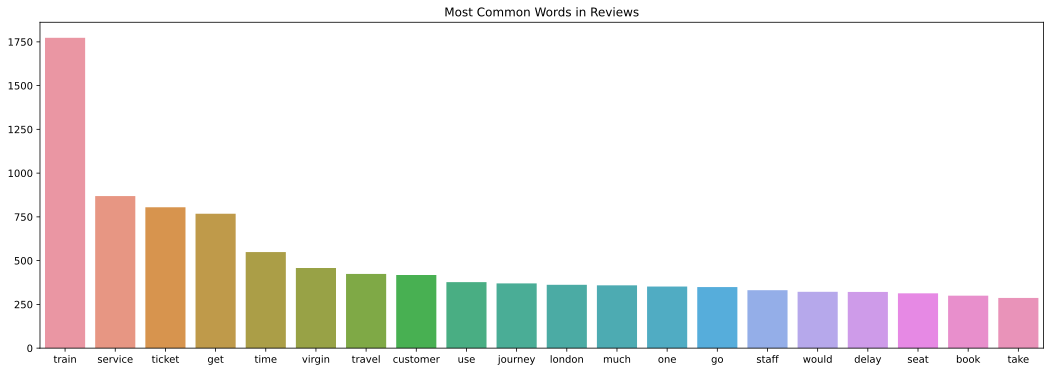

In [16]:
# a little bit prior knowledge of the baseline
# TF-IDF could give us a pretty good score without any other optimization
word_freq = Counter(text_clean)
word_freq.most_common(20)
words = [word[0] for word in word_freq.most_common(20)]
counts = [word[1] for word in word_freq.most_common(20)]
fig = plt.figure(figsize=(18,6))
sns.barplot(x=words, y=counts)
plt.title('Most Common Words in Reviews')
plt.show()

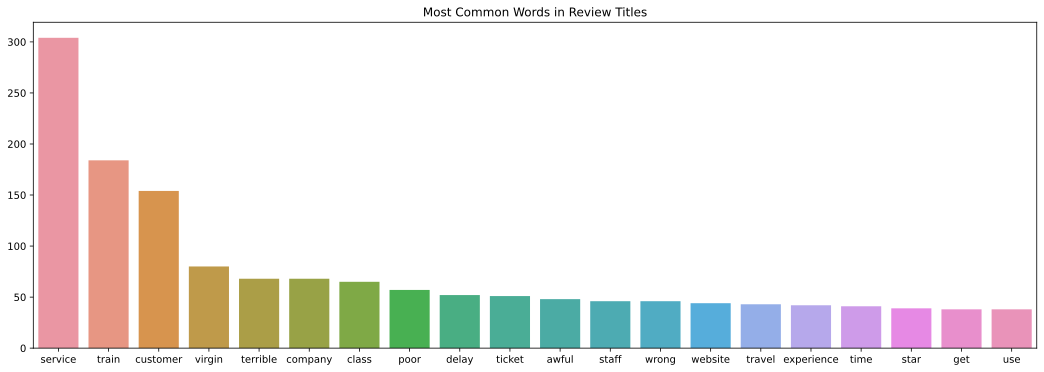

In [17]:
title_freq = Counter(title_clean)
title_freq.most_common(50)
words = [word[0] for word in title_freq.most_common(20)]
counts = [word[1] for word in title_freq.most_common(20)]
fig = plt.figure(figsize=(18,6))
sns.barplot(x=words, y=counts)
plt.title('Most Common Words in Review Titles')
plt.show()

In [19]:
'''def word_vec(input_list):
    sim_mat = []
    doc = nlp(str(input_list))
    for tk1 in doc:
        sim_tmp = []
        if tk1.has_vector and not tk1.is_oov:
            for tk2 in doc:
                sim_tmp.append(tk1.similarity(tk2))
        sim_mat.append(sim_tmp)
    return sim_mat

words = [word[0] for word in title_freq.most_common(50)]
sim_mat = word_vec(words)
fig = plt.figure(figsize=(18,18))
sns.heatmap(sim_mat, annot=words)
plt.title('Word Vectors of Most Common Words (n=50) in Review Titles')
plt.show()'''

"def word_vec(input_list):\n    sim_mat = []\n    doc = nlp(str(input_list))\n    for tk1 in doc:\n        sim_tmp = []\n        if tk1.has_vector and not tk1.is_oov:\n            for tk2 in doc:\n                sim_tmp.append(tk1.similarity(tk2))\n        sim_mat.append(sim_tmp)\n    return sim_mat\n\nwords = [word[0] for word in title_freq.most_common(50)]\nsim_mat = word_vec(words)\nfig = plt.figure(figsize=(18,18))\nsns.heatmap(sim_mat, annot=words)\nplt.title('Word Vectors of Most Common Words (n=50) in Review Titles')\nplt.show()"

In [18]:
# try LDA and countVec
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn import metrics
from spacy.lang.en import English
parser = English()
#from nltk.corpus import stopwords as sws
STOPLIST = set(sws.words('english') + list(ENGLISH_STOP_WORDS))
SYMBOLS = " ".join(string.punctuation).split(" ") + ["-", "...", "”", "”"]

/home/ym310/anaconda3/envs/pt3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


In [65]:
def tokenizeText(sample):
    SYMBOLS = " ".join(string.punctuation).split(" ") + ["-", "...", "”", "”","£", "…", "’s"] + ["\d+"]
    tokens = parser(sample)
    lemmas = []
    for tok in tokens:
        lemmas.append(tok.lemma_.lower().strip() if tok.lemma_ != "-PRON-" else tok.lower_)
    tokens = lemmas
    tokens = [tok for tok in tokens if tok not in ENGLISH_STOP_WORDS]
    tokens = [tok for tok in tokens if tok not in SYMBOLS]
    return tokens

In [68]:
# data loader - norm - vectorizer - transformer - estimator
# doc term matrix
vectorizer = CountVectorizer(tokenizer = tokenizeText, # ngram counter
                             max_df=0.95,
                             min_df=2, 
                             max_features=50,
                             ngram_range=(1,1),
                             stop_words='english')
# term frequency-inverse document frequency
transformer = TfidfTransformer()
# classifier
pipe = Pipeline([
    ('vectorizer', vectorizer),
    ('transformer', transformer),
])

tf = pipe.fit_transform(reviews_cp['title'] + reviews_cp['text'])

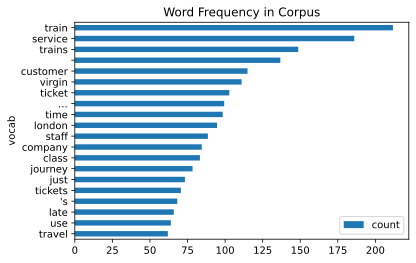

In [21]:
# most frequent words
vocab = vectorizer.get_feature_names() # booked cancelled, delayed late, money refund, seat, service, staff, website
vocab_cnt = np.asarray(tf.sum(axis=0))[0]
vocab_frame = pd.DataFrame({'vocab': vocab, 'count': vocab_cnt})
vocab_frame.sort_values('count', ascending=False).set_index('vocab')[:20].sort_values('count', ascending=True).plot(kind='barh')
plt.title('Word Frequency in Corpus')
plt.show()

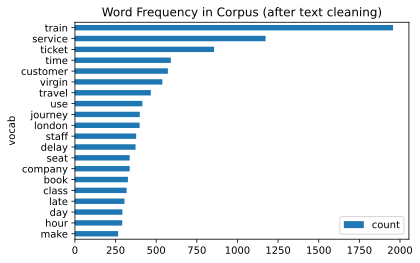

In [22]:
tfc = pipe.fit_transform(text_clean + title_clean)
vocab_c = vectorizer.get_feature_names()
vocab_c_cnt = np.asarray(tfc.sum(axis=0))[0]
vocab_c_frame = pd.DataFrame({'vocab': vocab_c, 'count': vocab_c_cnt})
vocab_c_frame.sort_values('count', ascending=False).set_index('vocab')[:20].sort_values('count', ascending=True).plot(kind='barh')
plt.title('Word Frequency in Corpus (after text cleaning)')
plt.show()
# book/buy, cancel/change, delay, experience, late, money/pay/price/, seat, service, staff, ticket, website

In [117]:
# LDA
#print(datetime.datetime.now())
lda = LatentDirichletAllocation(max_iter=10, 
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
#search_params = {'n_components': [5, 10, 15, 20], 'learning_decay': [.5, .7, .9]}
#model = GridSearchCV(lda, param_grid=search_params)
#model.fit(tfc)

LatentDirichletAllocation(learning_decay=0.9, learning_method='online',
                          learning_offset=50.0, n_components=5, random_state=0) -12395.381478747619 40.13473545202492


AttributeError: 'GridSearchCV' object has no attribute 'grid_scores_'

In [118]:
print(model.best_estimator_, model.best_score_, model.best_estimator_.perplexity(tfc))

LatentDirichletAllocation(learning_decay=0.9, learning_method='online',
                          learning_offset=50.0, n_components=5, random_state=0) -12395.381478747619 40.13473545202492


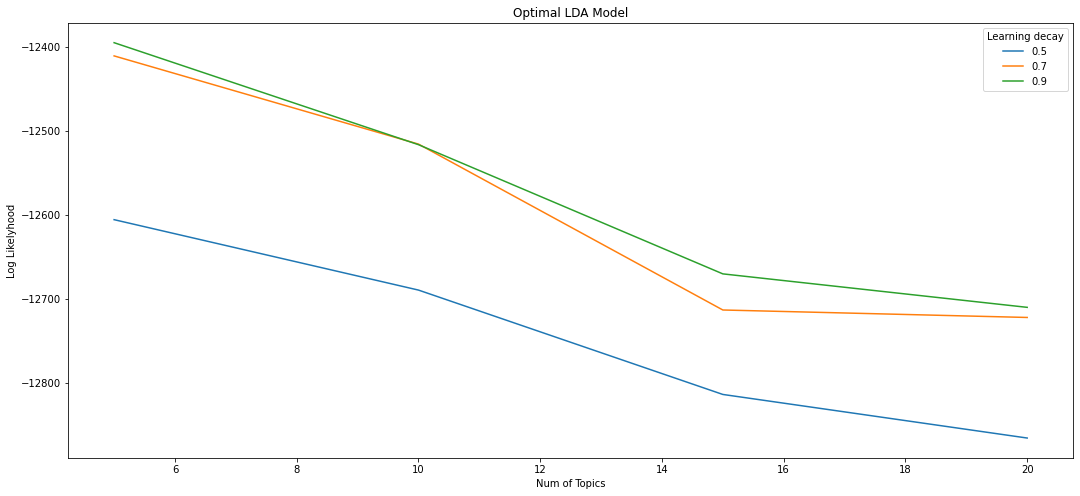

In [135]:
n_topics = [5, 10, 15, 20]
score_mean = model.cv_results_['mean_test_score']
gscore = model.cv_results_['params']

# Show graph
plt.figure(figsize=(18, 8))
plt.plot(n_topics, score_mean[:4], label='0.5')
plt.plot(n_topics, score_mean[4:8], label='0.7')
plt.plot(n_topics, score_mean[8:], label='0.9')
plt.title("Optimal LDA Model")
plt.xlabel("Num of Topics")
plt.ylabel("Log Likelyhood")
plt.legend(title='Learning decay', loc='best')
plt.show()

Plotting the log_likelihood againts num_of_topics, it clearly shows that the less number of topics, the better the model score. And learning_decay of 0.9 outperforms the other two when the number of topics less than 10. In our very initial guess, the high freq words(nouns) can be as much as 10-15, each distinct word could possibly be a distinct topics because the average length of reviews is small. A lower optimal number of distinct topics may be reasonable for this dataset. 

In [115]:
''' discard
# Top-N vocabs in topic words
lda.fit(tfc)
topic_word = lda.components_
print(topic_word.shape)
for topic_idx, topic in enumerate(topic_word):
    print("Topic #%d:" % topic_idx)
    print(" ".join([vocab_c[i] for i in topic.argsort()[:-15-1:-1]]))
'''

(5, 50)
Topic #0:
journey class day book wrong say ﻿1 website 2 way like buy terrible service train
Topic #1:
customer time staff seat cancel pay eurostar good southern terrible service train refund money people
Topic #2:
train travel london hour make people money terrible service refund late poor station rail price
Topic #3:
virgin use delay company work experience poor new need try return change terrible service train
Topic #4:
service ticket late refund terrible tell station price rail minute train money people travel poor


In [23]:
lda = LatentDirichletAllocation(max_iter=10, 
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)

In [24]:
# group reviews by companies, domain topic in each company's reviews
print(reviews_cp.groupby(['sources'])['title'].nunique().sort_values(ascending=False))
company_doc = reviews_cp.groupby('sources').agg({'text': lambda x: ' '.join(x), 'title': lambda x: ' '.join(x)})
#company_doc.shape (17, 2)
company_doc.index.tolist()

sources
www.virgintrains.co.uk                     470
www.southernrailway.com                    257
www.gwr.com                                179
www.eurostar.com                           178
www.virgintrainseastcoast.com              120
www.nationalrail.co.uk                      65
www.buytickets.crosscountrytrains.co.uk     20
www.tpexpress.co.uk                         20
www.southeasternrailway.co.uk               20
www.arrivatrainswales.co.uk                 20
www.eastmidlandstrains.co.uk                20
www.grandcentralrail.com                    19
www.southwesternrailway.com                 13
chilternrailways.co.uk                       8
www.londonnorthwesternrailway.co.uk          8
sleeper.scot                                 6
www.hulltrains.co.uk                         2
Name: title, dtype: int64


['chilternrailways.co.uk',
 'sleeper.scot',
 'www.arrivatrainswales.co.uk',
 'www.buytickets.crosscountrytrains.co.uk',
 'www.eastmidlandstrains.co.uk',
 'www.eurostar.com',
 'www.grandcentralrail.com',
 'www.gwr.com',
 'www.hulltrains.co.uk',
 'www.londonnorthwesternrailway.co.uk',
 'www.nationalrail.co.uk',
 'www.southeasternrailway.co.uk',
 'www.southernrailway.com',
 'www.southwesternrailway.com',
 'www.tpexpress.co.uk',
 'www.virgintrains.co.uk',
 'www.virgintrainseastcoast.com']

In [166]:
# best model
best_lda_model = model.best_estimator_
# create DTM  populated with token counts to represent the reviews. 
lda_dtm = best_lda_model.transform(tfc)
lda_fea = best_lda_model.components_
for topic_idx, topic in enumerate(lda_fea):
    print("Topic #%d:" % topic_idx)
    print(" ".join([vocab_c[i] for i in topic.argsort()[:-10-1:-1]]))

Topic #0:
journey london class day say wrong ﻿1 2 website way
Topic #1:
time customer staff seat book pay good southern make eurostar
Topic #2:
train travel late hour make refund people eurostar money london
Topic #3:
virgin use delay company cancel work experience new try poor
Topic #4:
service ticket tell station terrible price rail minute train change


In [188]:
# each doc is a mixture of topics/a distribution over topics
doc_topic_dist = pd.DataFrame(lda_dtm)
doc_topic_dist.head(20)

,0,1,2,3,4
0,0.2,0.2,0.2,0.2,0.2
1,0.1,0.1,0.1,0.6,0.1
2,0.2,0.2,0.2,0.2,0.2
3,0.1,0.1,0.1,0.1,0.6
4,0.2,0.2,0.2,0.2,0.2
5,0.2,0.2,0.2,0.2,0.2
6,0.2,0.2,0.2,0.2,0.2
7,0.1,0.1,0.1,0.1,0.6
8,0.6,0.1,0.1,0.1,0.1
9,0.2,0.2,0.2,0.2,0.2


In [25]:
# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

In [44]:
# topic distribution -- company
company_doc['title'].map(lambda x: re.sub(r'\W+', ' ', x))
company_doc['text'].map(lambda x: re.sub(r'\W+', ' ', x))
#company_doc['title'] = clean_up(company_doc['title'])
#title_clean = ' '.join(title_clean).split()
#company_doc['text'] = clean_up(company_doc['text'])
#text_clean = ' '.join(text_clean).split()

tf_doc = pipe.fit_transform(company_doc['title'] + company_doc['text'])
vocab_c = vectorizer.get_feature_names()
lda = LatentDirichletAllocation(learning_decay=0.7, learning_method='online',
                          learning_offset=10.0, n_components=5, random_state=0)
lda.fit(tf_doc)
topic_names = lda.n_components # =5
doc_names = company_doc.index
lda_dtm = lda.transform(tf_doc)

In [45]:
lda_fea = lda.components_
for topic_idx, topic in enumerate(lda_fea):
    print("Topic #%d:" % topic_idx)
    print(" ".join([vocab_c[i] for i in topic.argsort()[:-10-1:-1]]))

Topic #0:
 hours 2 late just train delayed money minutes class
Topic #1:
train money journey  rail delayed staff ticket london 's
Topic #2:
poor delayed website times tickets experience travel journey hours travelling
Topic #3:
class staff just train day booked experience hour seats way
Topic #4:
train  ticket london time company customer journey virgin …


In [46]:
# dataframe
topic_names = [str(i) for i in range(lda.n_components)] # n=5
doc_names = company_doc.index
print(lda_dtm.shape, topic_names, doc_names)
df_doc_topic = pd.DataFrame(np.round(lda_dtm, 2), columns=topic_names, index=doc_names)

#dominant topic for each document
dominant_topic = np.argmax(df_doc_topic.values, axis=1)
df_doc_topic['dominant_topic'] = dominant_topic

# Apply Style
df_document_topics = df_doc_topic.style.applymap(color_green).applymap(make_bold)
df_document_topics

(17, 5) ['0', '1', '2', '3', '4'] Index(['chilternrailways.co.uk', 'sleeper.scot', 'www.arrivatrainswales.co.uk',
       'www.buytickets.crosscountrytrains.co.uk',
       'www.eastmidlandstrains.co.uk', 'www.eurostar.com',
       'www.grandcentralrail.com', 'www.gwr.com', 'www.hulltrains.co.uk',
       'www.londonnorthwesternrailway.co.uk', 'www.nationalrail.co.uk',
       'www.southeasternrailway.co.uk', 'www.southernrailway.com',
       'www.southwesternrailway.com', 'www.tpexpress.co.uk',
       'www.virgintrains.co.uk', 'www.virgintrainseastcoast.com'],
      dtype='object', name='sources')


,0,1,2,3,4,dominant_topic
sources,,,,,,
chilternrailways.co.uk,0.040000,0.040000,0.040000,0.040000,0.840000,4
sleeper.scot,0.040000,0.040000,0.040000,0.040000,0.840000,4
www.arrivatrainswales.co.uk,0.040000,0.040000,0.040000,0.040000,0.830000,4
www.buytickets.crosscountrytrains.co.uk,0.030000,0.030000,0.030000,0.030000,0.860000,4
www.eastmidlandstrains.co.uk,0.040000,0.040000,0.040000,0.040000,0.860000,4
www.eurostar.com,0.030000,0.030000,0.030000,0.030000,0.880000,4
www.grandcentralrail.com,0.030000,0.030000,0.030000,0.030000,0.860000,4
www.gwr.com,0.030000,0.030000,0.030000,0.030000,0.880000,4
www.hulltrains.co.uk,0.080000,0.080000,0.080000,0.660000,0.090000,3


It is surprised to see that the main topic of reviews among different sources are very closely matched. I tried to tune the pipeline using variety hyperparameter combination, however I always received similar results. People show strong disappointments to the delay of trains and staffs.

(as we only have two samples from 'www.hulltrains.co.uk', the results might not be accurately reflect the dominant topic of hull trains.) To this point, let's try to split the dataset

In [29]:
company_dp = company_doc.drop(['www.hulltrains.co.uk', 
                               'www.buytickets.crosscountrytrains.co.uk',
                               'www.tpexpress.co.uk',
                               'www.southeasternrailway.co.uk',
                               'www.arrivatrainswales.co.uk', 
                               'www.eastmidlandstrains.co.uk', 
                                'www.grandcentralrail.com',       
                                'www.southwesternrailway.com',         
                                'chilternrailways.co.uk',                  
                                'www.londonnorthwesternrailway.co.uk',        
                                'sleeper.scot'         ])

In [47]:
tf_dp = pipe.fit_transform(company_dp['title'] + company_dp['text'])
vocab_c = vectorizer.get_feature_names()
lda = LatentDirichletAllocation(learning_decay=0.9, learning_method='online',
                          learning_offset=25.0, n_components=5, random_state=0)
lda.fit(tf_dp)
topic_names = [str(i) for i in range(lda.n_components)] # n=5
doc_names = company_dp.index
lda_dtm = lda.transform(tf_dp)

In [48]:
lda_fea = lda.components_
for topic_idx, topic in enumerate(lda_fea):
    print("Topic #%d:" % topic_idx)
    print(" ".join([vocab_c[i] for i in topic.argsort()[:-10-1:-1]]))

Topic #0:
delay able 1st disgrace east claim working euston excellent cancellations
Topic #1:
virgin newcastle edinburgh coast excellent response claim cross 4 end
Topic #2:
franchise claim coast rip delay sent euston overcrowded taken stop
Topic #3:
birmingham disgrace cross card change avoid coast cancellations kings ’s
Topic #4:
paris gwr southern change response help travelling extra delay railway


In [49]:
doc_names = company_dp.index
df_doc_topic = pd.DataFrame(np.round(lda_dtm, 2), columns=topic_names, index=doc_names)

#dominant topic for each document
dominant_topic = np.argmax(df_doc_topic.values, axis=1)
df_doc_topic['dominant_topic'] = dominant_topic

# Apply Style
df_document_topics = df_doc_topic.style.applymap(color_green).applymap(make_bold)
df_document_topics

,0,1,2,3,4,dominant_topic
sources,,,,,,
www.eurostar.com,0.050000,0.050000,0.050000,0.050000,0.810000,4
www.gwr.com,0.050000,0.050000,0.050000,0.050000,0.790000,4
www.nationalrail.co.uk,0.060000,0.050000,0.050000,0.780000,0.050000,3
www.southernrailway.com,0.050000,0.050000,0.050000,0.050000,0.800000,4
www.virgintrains.co.uk,0.050000,0.790000,0.050000,0.050000,0.050000,1
www.virgintrainseastcoast.com,0.040000,0.830000,0.040000,0.040000,0.040000,1


If we group the reviews by sources, the freq of destinations increase.

In [62]:
# topic distribution over time
#reviews_cp['week'] = reviews['date'].dt.strftime('%U')
season_doc = reviews[['date', 'text', 'title']]
len(season_doc.index.tolist())

1621

In [63]:
season_doc.keys()

Index(['date', 'text', 'title'], dtype='object')

In [66]:
season_doc['title'].map(lambda x: re.sub(r'\W+', ' ', x))
season_doc['text'].map(lambda x: re.sub(r'\W+', ' ', x))
topic_words = []
'''
for topic_idx, topic in enumerate(lda_fea):
    #print("Topic #%d:" % topic_idx)
    topic_words.append([vocab_c[i] for i in topic.argsort()[:-10-1:-1]])

for comparison only
topic_words = [['hours', 'late' 'train', 'delayed', 'money', 'minutes', 'class'],
               ['train', 'money', 'journey', 'rail', 'delayed', 'staff', 'ticket'],
               ['poor', 'delayed', 'website', 'times', 'tickets', 'experience', 'travel'],
               ['class', 'staff', 'train', 'day', 'booked', 'experience', 'seats'],
               ['train',  'ticket', 'time', 'company', 'customer', 'journey', 'virgin']]
'''
#season_doc.loc[].rolling(window=8).mean().plot(figsize(18,6))

'\nfor topic_idx, topic in enumerate(lda_fea):\n    #print("Topic #%d:" % topic_idx)\n    topic_words.append([vocab_c[i] for i in topic.argsort()[:-10-1:-1]])\n\nfor comparison only\ntopic_words = [[\'hours\', \'late\' \'train\', \'delayed\', \'money\', \'minutes\', \'class\'],\n               [\'train\', \'money\', \'journey\', \'rail\', \'delayed\', \'staff\', \'ticket\'],\n               [\'poor\', \'delayed\', \'website\', \'times\', \'tickets\', \'experience\', \'travel\'],\n               [\'class\', \'staff\', \'train\', \'day\', \'booked\', \'experience\', \'seats\'],\n               [\'train\',  \'ticket\', \'time\', \'company\', \'customer\', \'journey\', \'virgin\']]\n'

In [69]:
tf_s = pipe.fit_transform(season_doc['title'] + season_doc['text'])
vocab_s = vectorizer.get_feature_names()
lda = LatentDirichletAllocation(learning_decay=0.8, learning_method='online',
                          learning_offset=10.0, n_components=5, random_state=0)
lda.fit(tf_s)
topic_names = [str(i) for i in range(lda.n_components)]
doc_names = season_doc.index
lda_dtm = lda.transform(tf_s)

lda_fea = lda.components_
for topic_idx, topic in enumerate(lda_fea):
    print("Topic #%d:" % topic_idx)
    print(" ".join([vocab_s[i] for i in topic.argsort()[:-10-1:-1]]))

Topic #0:
class  virgin train london seats staff travel way seat
Topic #1:
company worst use website service new eurostar experience 's trains
Topic #2:
train trains delayed cancelled service time late station minutes hour
Topic #3:
rail southern day money late journey service work bad train
Topic #4:
ticket customer service refund tickets just  train told website


In [117]:
df_doc_topic = pd.DataFrame(np.round(lda_dtm, 2), columns=topic_names, index=doc_names)

#dominant topic for each document

season_doc['dominant_topic'] = np.argmax(df_doc_topic.values, axis=1)
season_doc.head()

/home/ym310/anaconda3/envs/pt3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,date,text,title,dominant_topic
date,,,,
2011-05-28 15:00:36+00:00,2011-05-28 15:00:36+00:00,I always use the national rail enquiry site wh...,Check it out.,3
2011-11-20 20:43:09+00:00,2011-11-20 20:43:09+00:00,"First class is very spacious, free wireless in...","Reasonable prices, good service",0
2015-01-07 23:32:34+00:00,2015-01-07 23:32:34+00:00,Virgin trains customer service are amazing,Fantastic customer service,4
2015-01-13 12:26:52+00:00,2015-01-13 12:26:52+00:00,Saved about £50 on a single trip using Nationa...,Very good,1
2015-02-11 13:20:32+00:00,2015-02-11 13:20:32+00:00,I was at traveling back to Coventry from Wolve...,Best customer service,4


In [166]:
df_topic_date = pd.concat([season_doc['date'], season_doc['dominant_topic']], axis=1)
df_topic_date.index = df_topic_date['date']
for i in range(5):
    print(df_topic_date.loc[df_topic_date['dominant_topic'] == i ].shape)
g = df_topic_date.groupby(pd.Grouper(freq='M'))
result = g.count()['date']
result

(560, 2)
(220, 2)
(347, 2)
(180, 2)
(314, 2)


date
2011-05-31 00:00:00+00:00      1
2011-06-30 00:00:00+00:00      0
2011-07-31 00:00:00+00:00      0
2011-08-31 00:00:00+00:00      0
2011-09-30 00:00:00+00:00      0
                            ... 
2018-03-31 00:00:00+00:00     93
2018-04-30 00:00:00+00:00    107
2018-05-31 00:00:00+00:00     99
2018-06-30 00:00:00+00:00    139
2018-07-31 00:00:00+00:00    120
Freq: M, Name: date, Length: 87, dtype: int64

In [79]:
def timestamp_to_date(timestamp):
    return datetime.fromtimestamp(timestamp)

In [84]:
# trend of topics
from scipy.stats import binom
def cox_stuart_test(df):
    
    df=pd.Series(df).fillna(value=0).to_list()
    if df[-1]==0: 
        df=df[:-1]

    if len(df)%2!=0:
        del df[len(df)//2]
    left=df[:len(df)//2]
    right=df[len(df)//2:]
    diff=[left[i]-right[i] for i in range(len(right))]
    counter_pos=0
    counter_neg=0

    for i, n in enumerate(diff):
        if n>0:
            counter_pos+=1
        elif n<0:
            counter_neg +=1
    p_val=binom.cdf(np.min([counter_pos, counter_neg]), counter_pos+counter_neg, 0.5)

    trend_diff=-np.sum(diff)/len(diff)

    return p_val<0.05, trend_diff, p_val

def calculate_trending_test(df, category):
    df.reset_index(drop=True, inplace=True)
    result=[]
    for i in range(lda.n_components):
        result.append(cox_stuart_test(list(df.loc[df['topic']==i, category])))
    result=pd.DataFrame(result, columns=['test', '% diff', 'p-value'])
    
    result_sorted=pd.concat([pd.DataFrame([topic_names[int(x)] for x in list(result.index)], 
                                              columns=['topic']),
                               result
                              ],
                              axis=1)
    result_sorted.sort_values(['test', '% diff'], inplace=True, ascending=False)
    return result_sorted

min_date = np.min(season_doc['date'])
max_date = np.max(season_doc['date'])

In [167]:
def dfs_trending_count(df, freq):
    #dfs_trend = dict()
    #for freq in ['D', 'W', 'M']:
    dfs_trend = pd.DataFrame(columns=['date', 'count', 'topic'])
    for i in range(lda.n_components):
        df_topic = df.loc[df['dominant_topic'] == i]
        g = df_topic.groupby(pd.Grouper(freq=freq))
        result = g.count()['date']
        result = pd.DataFrame({'date': result.index, 
                               'count': result.values, 
                               'topic':i})    
        dfs_trend = pd.concat([dfs_trend, result], axis=0, sort=True)
    print(df.shape, dfs_trend.shape)
    return dfs_trend


In [171]:
df_result=pd.DataFrame()
dfs_trend_M = dfs_trending_count(df_topic_date, 'M')

df = calculate_trending_test(dfs_trend_M, 'count')
df['type'] = 'count'
df.reset_index(inplace=True)    
df_result=pd.concat([df_result, df], axis=1)
df_result.head()

(1621, 2) (293, 3)


,index,topic,test,% diff,p-value,type
0,0,0,True,13.850000,1.818989e-12,count
1,2,2,True,11.631579,3.814697e-06,count
2,4,4,True,9.952381,4.768372e-07,count
3,1,1,True,6.714286,4.768372e-07,count
4,3,3,True,4.139535,2.037268e-09,count


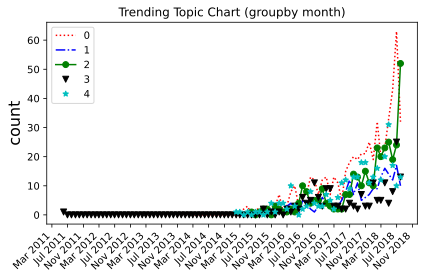

In [174]:
#increasing/decreasing trends
import matplotlib.dates as mdates
graph_type = 'increasing'
trending_topics={
    0: 'r:', 
    1: 'b-.', 
    2: 'go-',
    3: 'kv',
    4: 'c*',
}
fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
if freq == 'M':
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=4))
elif freq == 'W':
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=4))
elif freq == 'D':
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=4))
ax.set_ylabel('count', fontsize=16) 

for i, mode in trending_topics.items():
    d = pd.Series(list(dfs_trend_M.loc[dfs_trend_M['topic'] == i, 'count']), 
                      index=list(dfs_trend_M.loc[dfs_trend_M['topic'] == i, 'date']))
    ax.plot(d, mode, label=i)

legend_loc='upper left' if graph_type=='increasing' else 'upper right'
lgnd = plt.legend(loc=legend_loc, scatterpoints=1, fontsize=10)
plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title("Trending Topic Chart (groupby month)")
fig.tight_layout()

In [175]:
df_result=pd.DataFrame()
dfs_trend_W = dfs_trending_count(df_topic_date, 'W')

df = calculate_trending_test(dfs_trend_W, 'count')
df['type'] = 'count'
df.reset_index(inplace=True)    
df_result=pd.concat([df_result, df], axis=1)
df_result.head()

(1621, 2) (1256, 3)


,index,topic,test,% diff,p-value,type
0,0,0,True,3.183908,1.147944e-41,count
1,2,2,True,2.658537,2.882760e-12,count
2,4,4,True,2.282609,2.568782e-16,count
3,1,1,True,1.538462,1.059933e-13,count
4,3,3,True,0.951872,5.686867e-25,count


<Figure size 1296x576 with 0 Axes>

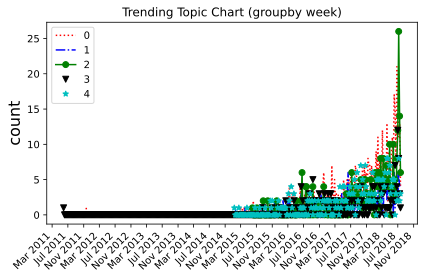

In [178]:
plt.figure(figsize=(18, 8))
fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
if freq == 'M':
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=4))
elif freq == 'W':
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=4))
elif freq == 'D':
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=4))
ax.set_ylabel('count', fontsize=16) 

for i, mode in trending_topics.items():
    d = pd.Series(list(dfs_trend_W.loc[dfs_trend_W['topic'] == i, 'count']), 
                      index=list(dfs_trend_W.loc[dfs_trend_W['topic'] == i, 'date']))
    ax.plot(d, mode, label=i)

legend_loc='upper left' if graph_type=='increasing' else 'upper right'
lgnd = plt.legend(loc=legend_loc, scatterpoints=1, fontsize=10)
plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title("Trending Topic Chart (groupby week)")
fig.tight_layout()

In [177]:
df_result=pd.DataFrame()
dfs_trend_D = dfs_trending_count(df_topic_date, 'W')

df = calculate_trending_test(dfs_trend_D, 'count')
df['type'] = 'count'
df.reset_index(inplace=True)    
df_result=pd.concat([df_result, df], axis=1)
df_result.head()

(1621, 2) (1256, 3)


,index,topic,test,% diff,p-value,type
0,0,0,True,3.183908,1.147944e-41,count
1,2,2,True,2.658537,2.882760e-12,count
2,4,4,True,2.282609,2.568782e-16,count
3,1,1,True,1.538462,1.059933e-13,count
4,3,3,True,0.951872,5.686867e-25,count


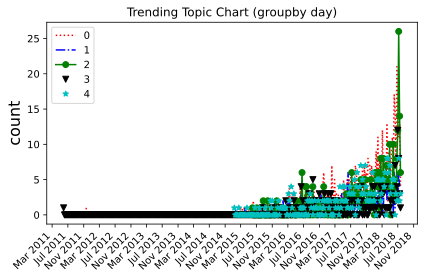

In [179]:
fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
if freq == 'M':
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=4))
elif freq == 'W':
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=4))
elif freq == 'D':
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=4))
ax.set_ylabel('count', fontsize=16) 

for i, mode in trending_topics.items():
    d = pd.Series(list(dfs_trend_D.loc[dfs_trend_D['topic'] == i, 'count']), 
                      index=list(dfs_trend_D.loc[dfs_trend_D['topic'] == i, 'date']))
    ax.plot(d, mode, label=i)

legend_loc='upper left' if graph_type=='increasing' else 'upper right'
lgnd = plt.legend(loc=legend_loc, scatterpoints=1, fontsize=10)
plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title("Trending Topic Chart (groupby day)")
fig.tight_layout()